In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Pancreas 14.5 -> 15.5 Unbalanced OT-ICNN

In [2]:
from moscot.problems.time import TemporalNeuralProblem, TemporalProblem
from moscot.datasets import simulate_data

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scanpy as sc

from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.geometry.pointcloud import PointCloud

import cellrank as cr
import scvelo as scv
import petsc4py
import slepc4py
scv.set_figure_params('scvelo', transparent=True, fontsize=20)

/shared-local/aoq951/miniforge3/envs/neuralot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


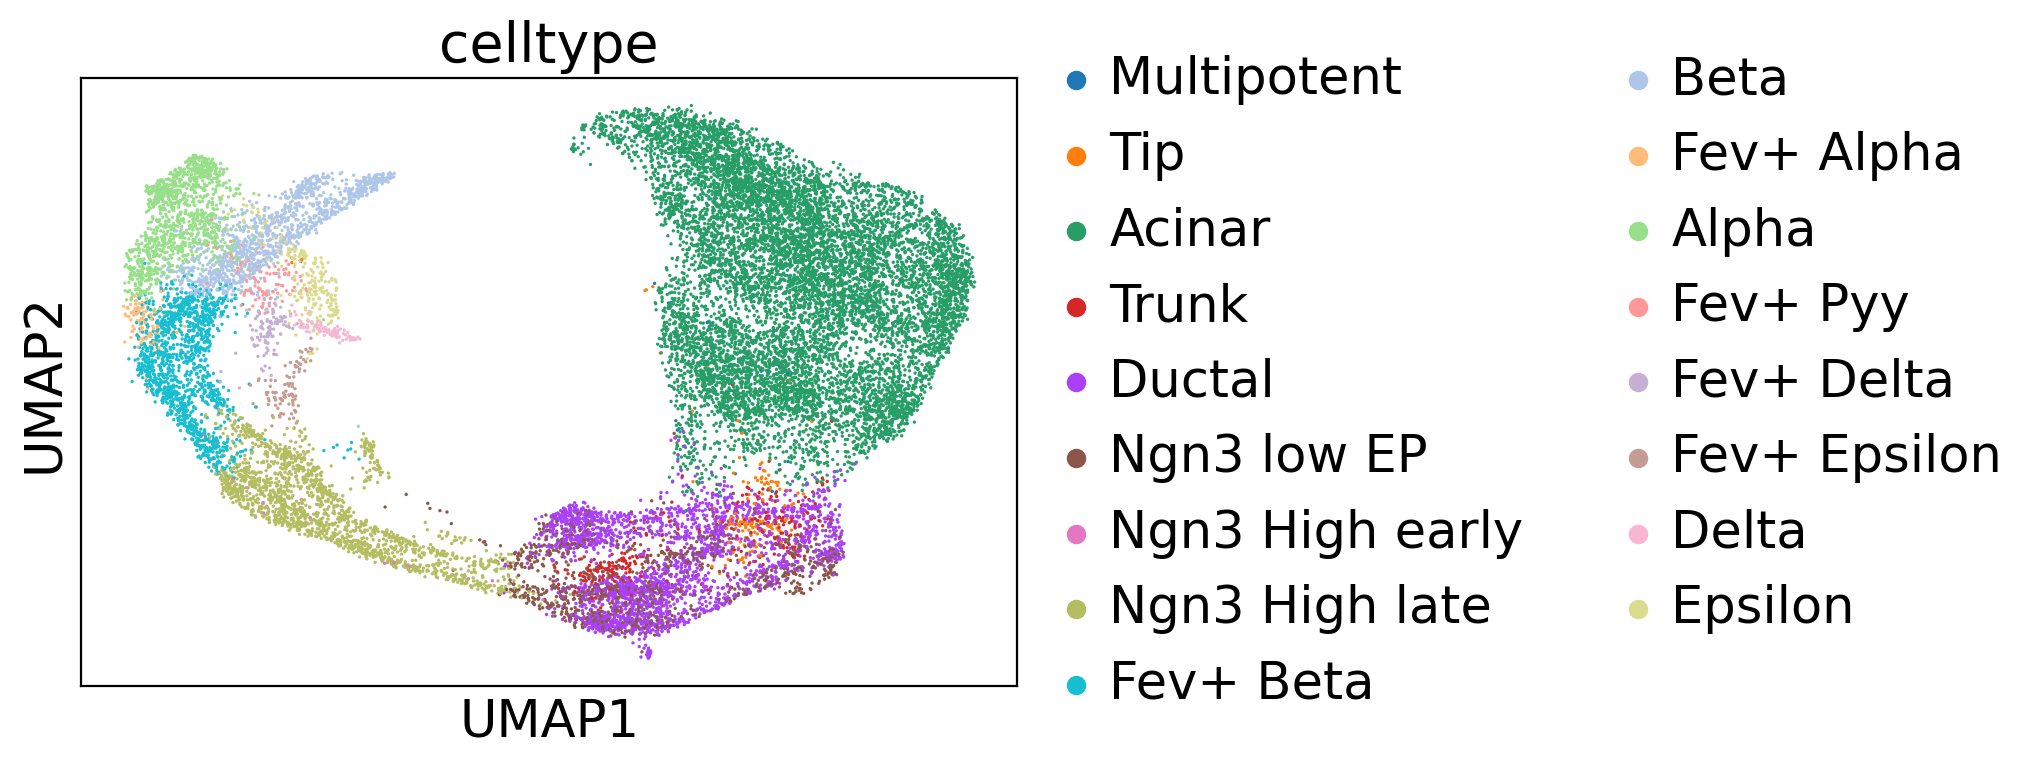

In [3]:
adata = sc.read_h5ad("data/1415_growth_rate.h5ad")
sc.pl.umap(adata, color="celltype")

In [4]:
tnp = TemporalNeuralProblem(adata)
tnp = tnp.prepare(time_key="day", joint_attr="X_pca")

In [5]:
tnp = tnp.solve(
    tau_a=0.85,
    tau_b=0.85,
    best_model_metric="sinkhorn_loss_forward",
)

INFO     Solving problem BirthDeathNeuralProblem[stage='prepared', shape=(9633, 10886)].                           


  0%|          | 0/25000 [00:00<?, ?it/s]

In [6]:
solution = tnp['14.5','15.5'].solution
solution

NeuralDualOutput[predicted_cost=170.484, best_loss=Array(15.691025, dtype=float32), sinkhorn_dist=32.26690673828125]

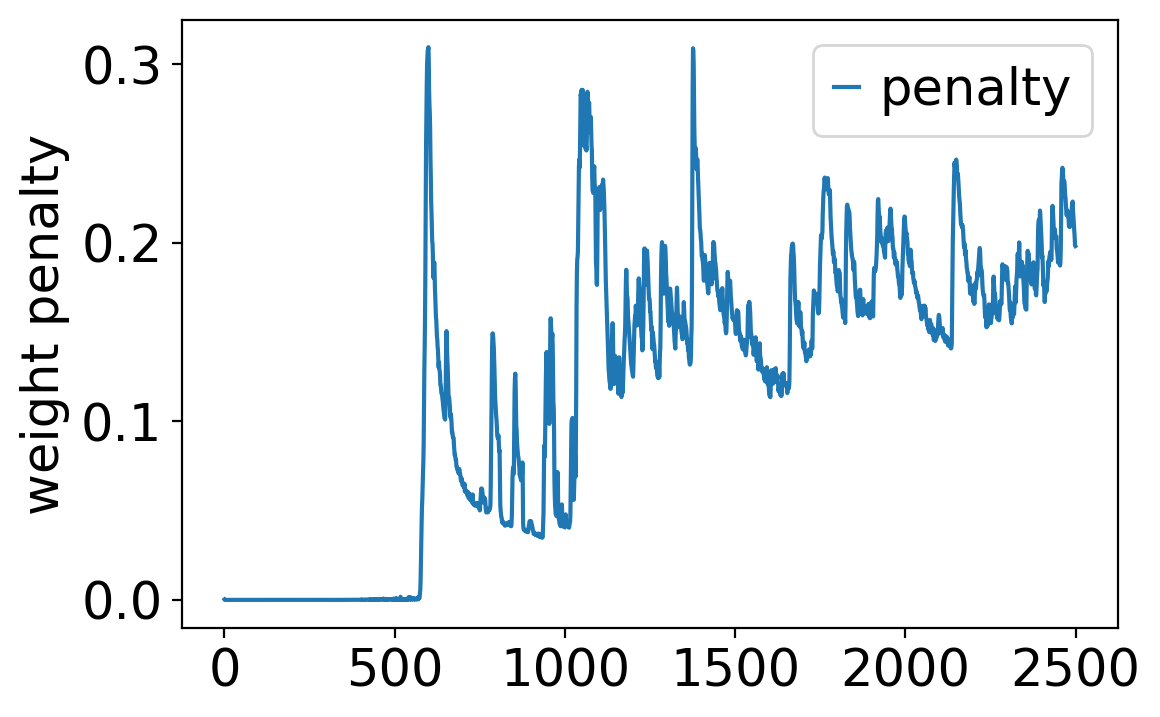

In [7]:
fig, ax = plt.subplots()
ax.plot(solution._training_logs["train_logs"]["penalty"], label="penalty")
ax.set_ylabel("weight penalty")
ax.legend()
plt.show()

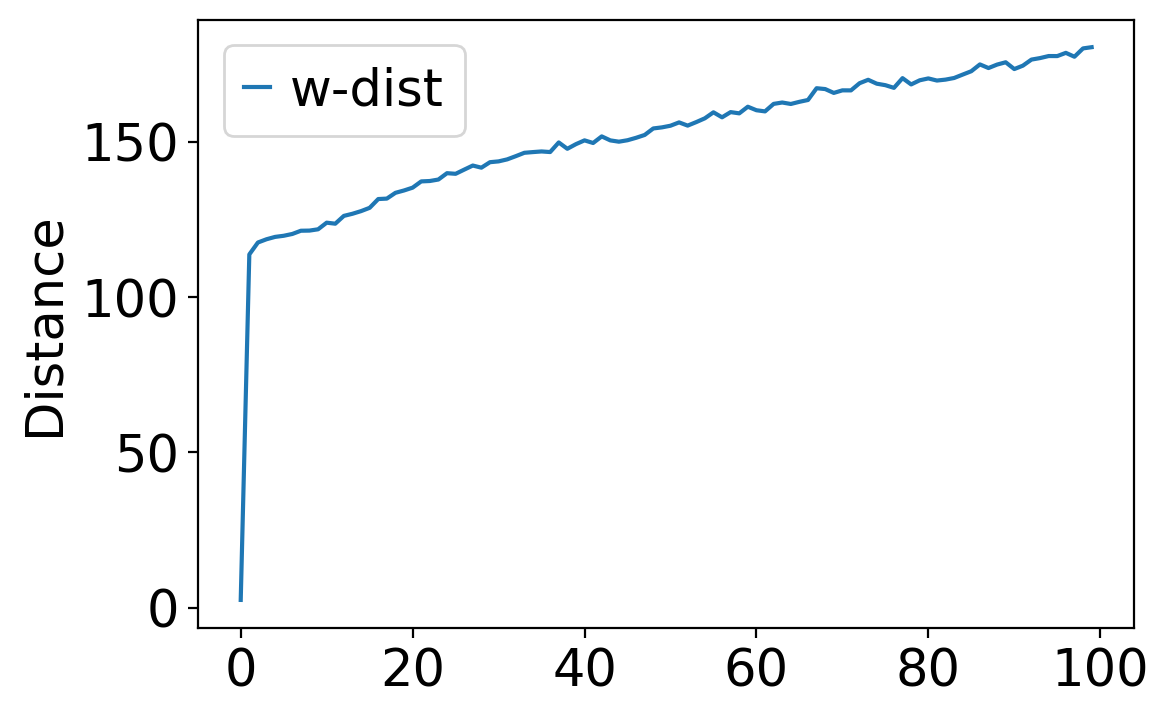

In [8]:
fig, ax = plt.subplots()
ax.plot(solution._training_logs["valid_logs"]["0_1_neural_dual_dist"], label="w-dist")
ax.set_ylabel("Distance")
ax.legend()
plt.show()

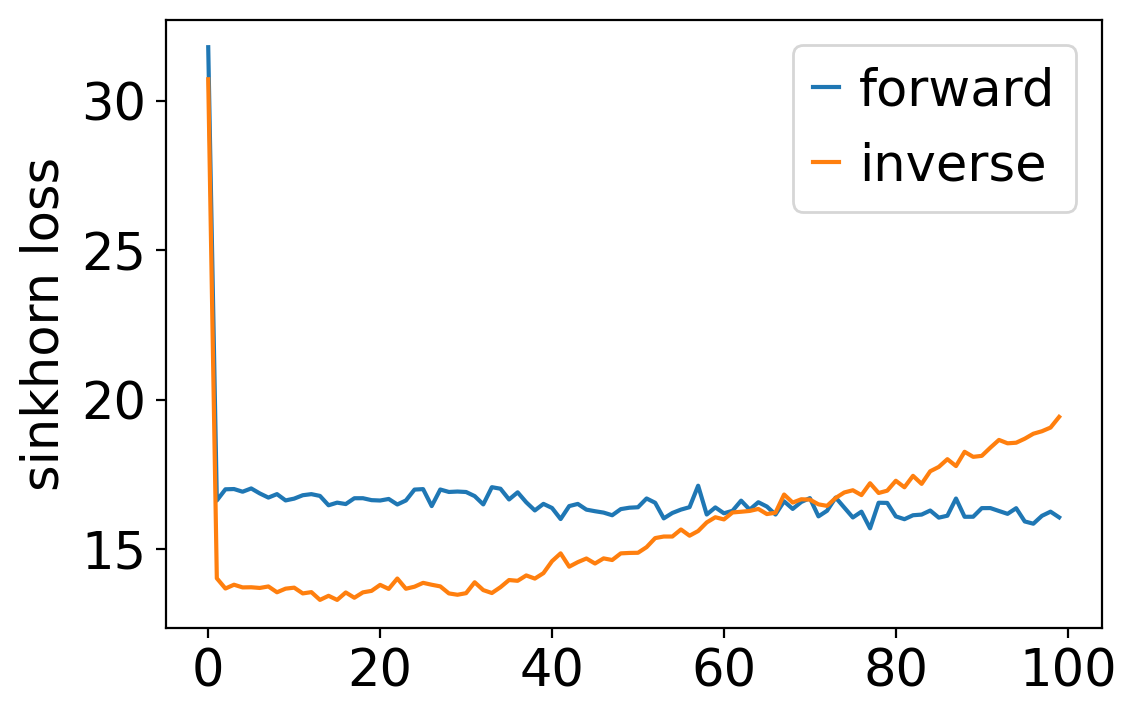

In [9]:
fig, ax = plt.subplots()
ax.plot(solution._training_logs["valid_logs"]["0_1_sinkhorn_loss_forward"], label="forward")
ax.plot(solution._training_logs["valid_logs"]["0_1_sinkhorn_loss_inverse"], label="inverse")
ax.set_ylabel("sinkhorn loss")
ax.legend()
plt.show()

In [10]:
# Prepare for Cellrank
source = jnp.array(adata.obsm["X_pca"].copy())
adata.obs["clusters"] = adata.obs["celltype"]
adata = adata[:, :50].copy()
adata.layers["velocity"] = solution.push(source) - source
adata.layers["velocity"] = np.asarray(adata.layers["velocity"])
adata.layers["pca"] = adata.obsm["X_pca"].copy()

# Velocity Stream Embedding

In [11]:
vk = cr.kernels.VelocityKernel(adata, xkey="pca")
vk.compute_transition_matrix()
adata.uns["velocity_graph"] = vk.transition_matrix

  0%|          | 0/20519 [00:00<?, ?cell/s]

  0%|          | 0/20519 [00:00<?, ?cell/s]

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


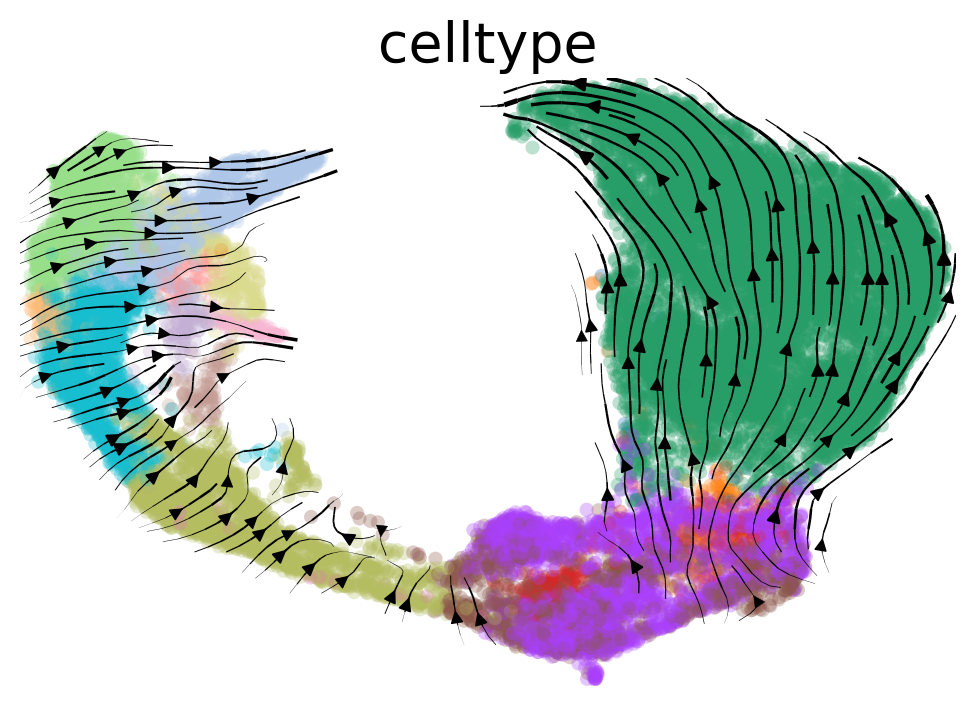

In [12]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color="celltype",smooth=0.5, legend_loc='none')

In [13]:
g = cr.estimators.GPCCA(vk)
g.compute_schur(n_components=20)

GPCCA[kernel=VelocityKernel[n=20519], initial_states=None, terminal_states=None]

# Macro/Terminalstates

In [14]:
g.compute_macrostates(n_states=9, cluster_key="celltype")

/shared-local/aoq951/miniforge3/envs/neuralot/lib/python3.10/site-packages/pygpcca/_gpcca.py:1274: UserWarning: Stationary distribution couldn't be calculated. Reason: Top eigenvector has both positive and negative entries. It has range = [-1.92025922252596e-10, 0.8453881397618969].
  warnings.warn(f"Stationary distribution couldn't be calculated. Reason: {e}.")


GPCCA[kernel=VelocityKernel[n=20519], initial_states=None, terminal_states=None]

/shared-local/aoq951/miniforge3/envs/neuralot/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/shared-local/aoq951/miniforge3/envs/neuralot/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


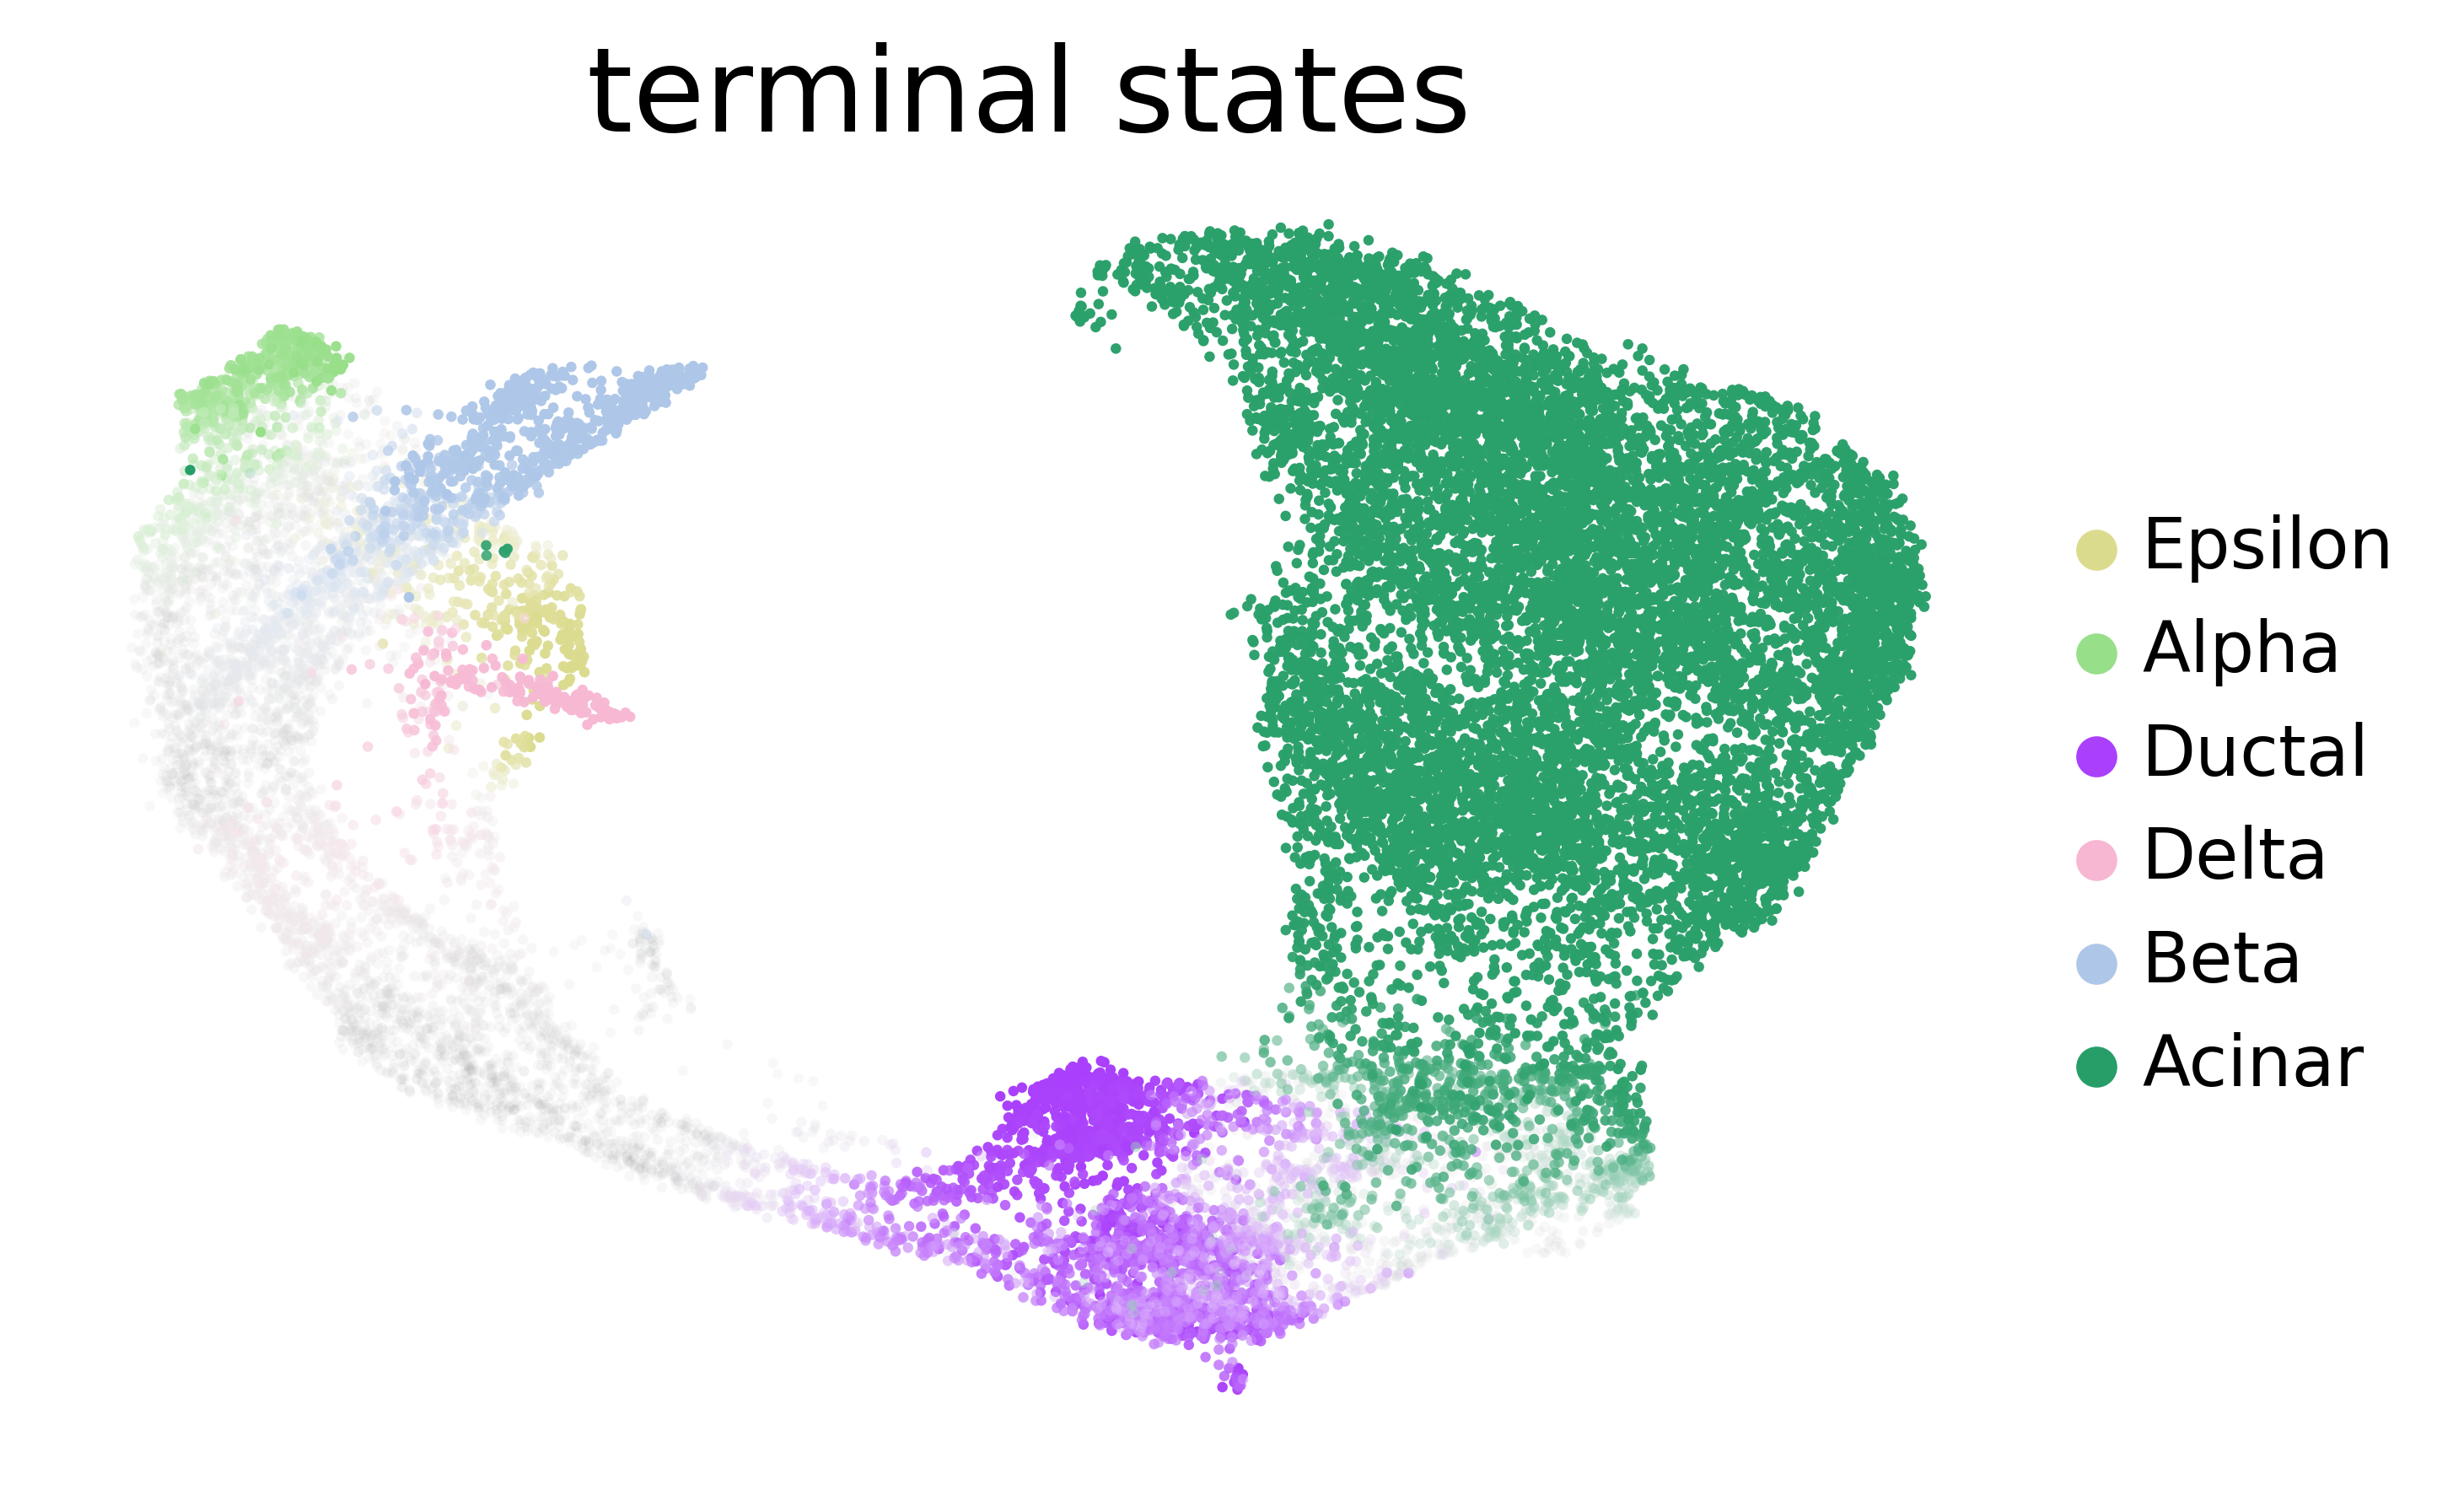

In [15]:
g.predict_terminal_states(method="top_n", n_states=6)
g.plot_macrostates(which="terminal",discrete=False, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

# Fate Probabilities

  0%|          | 0/6 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


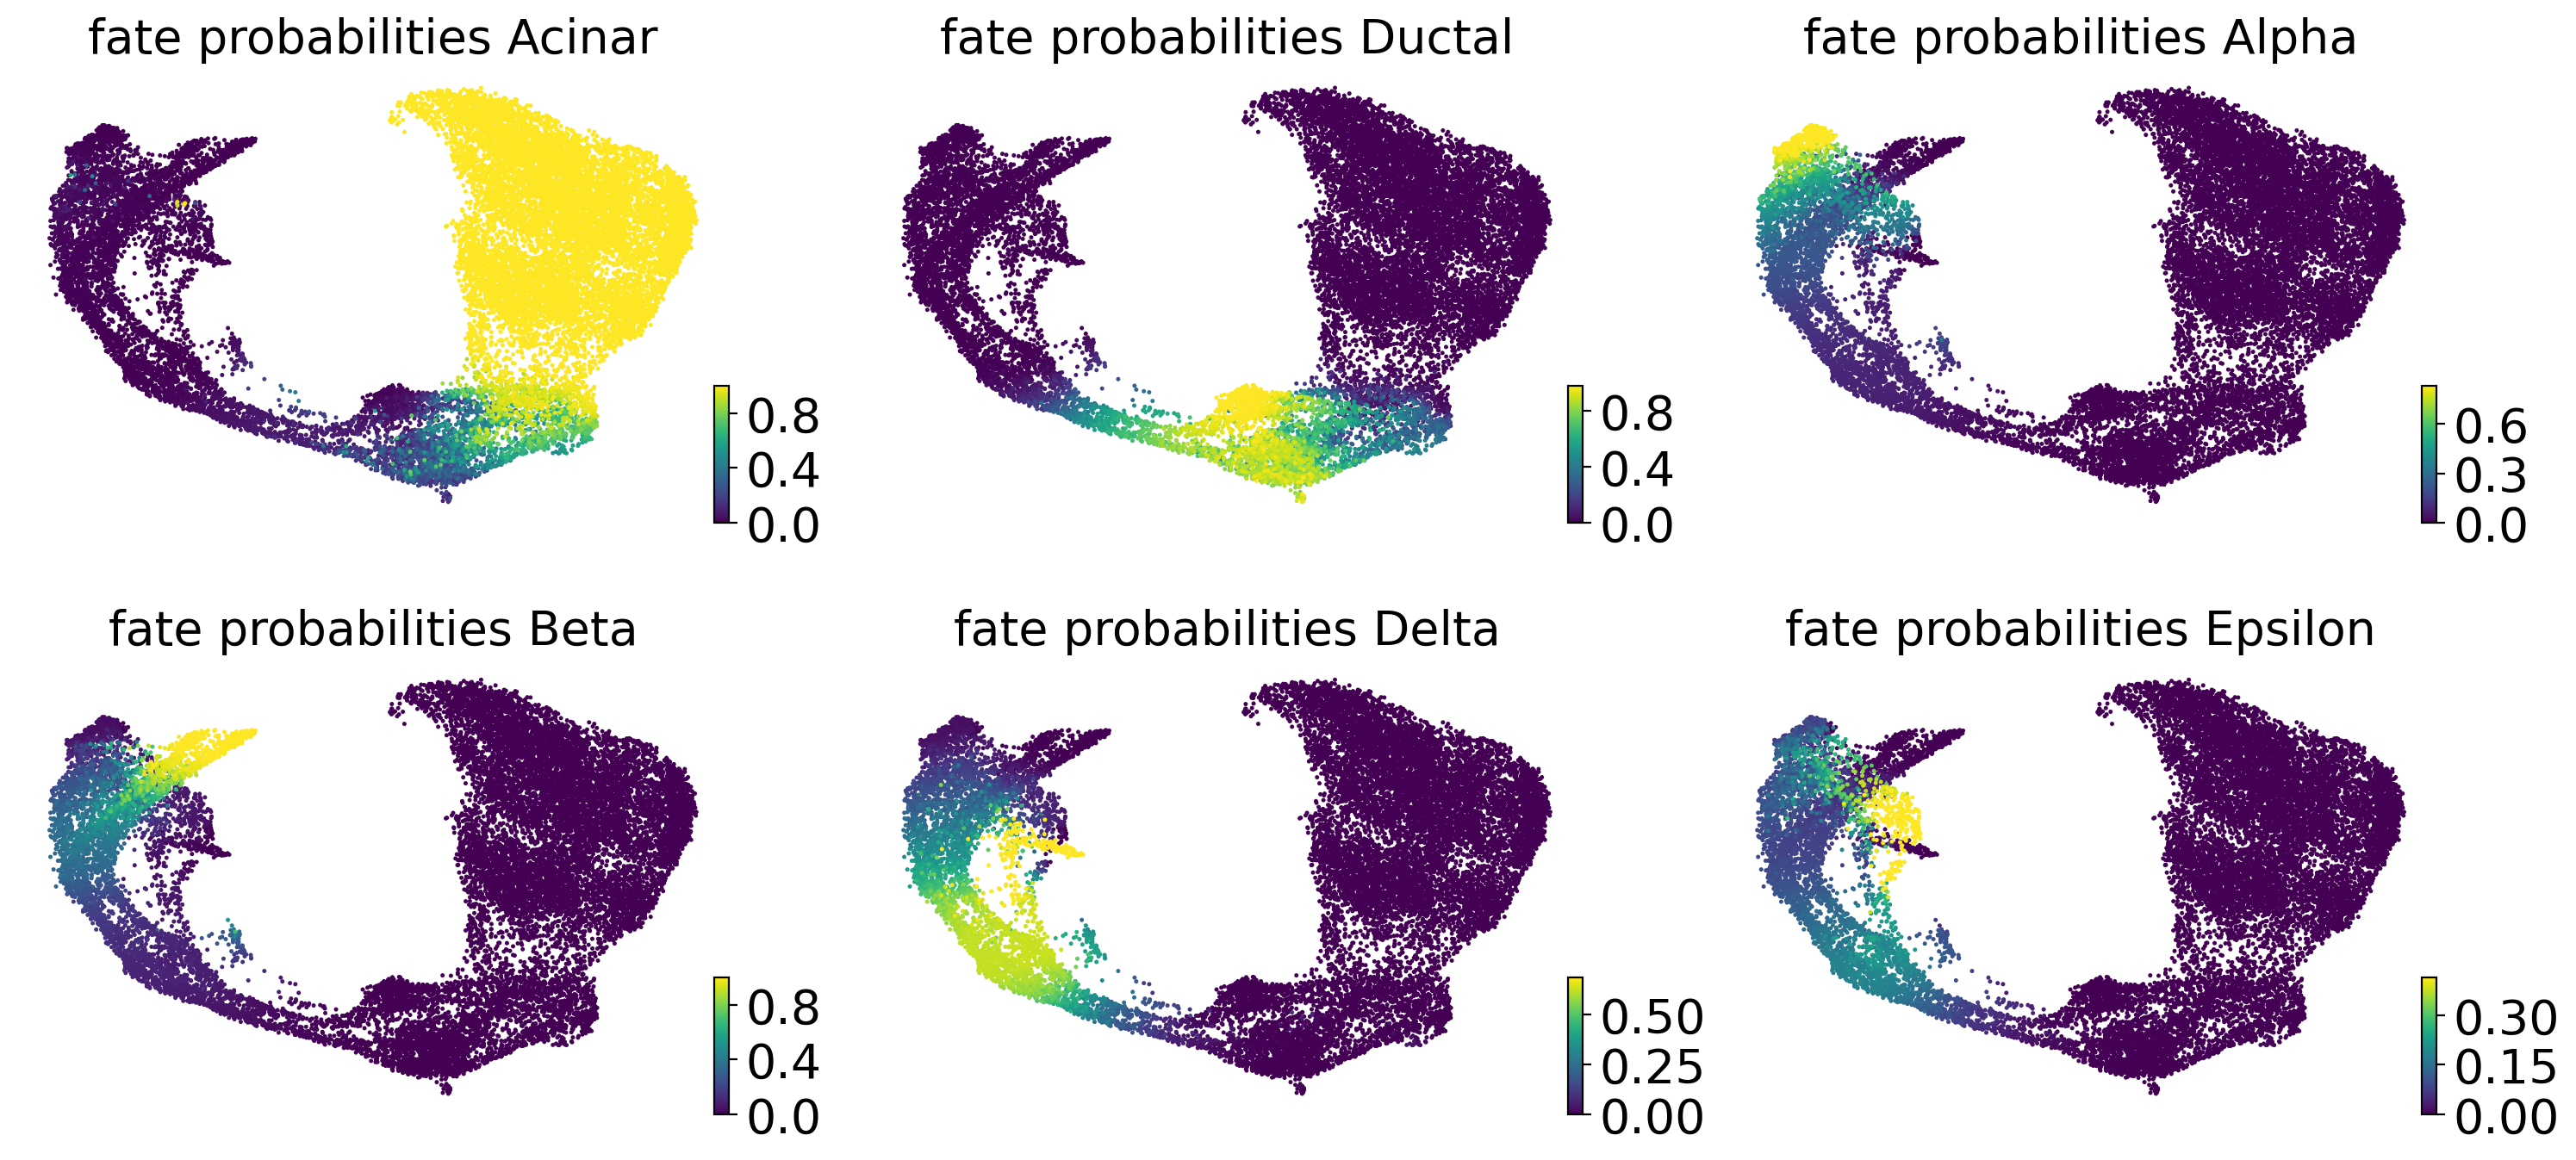

In [16]:
g.set_terminal_states(
    [
        "Acinar", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"
    ]
)
g.compute_fate_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu')
g.plot_fate_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=3)

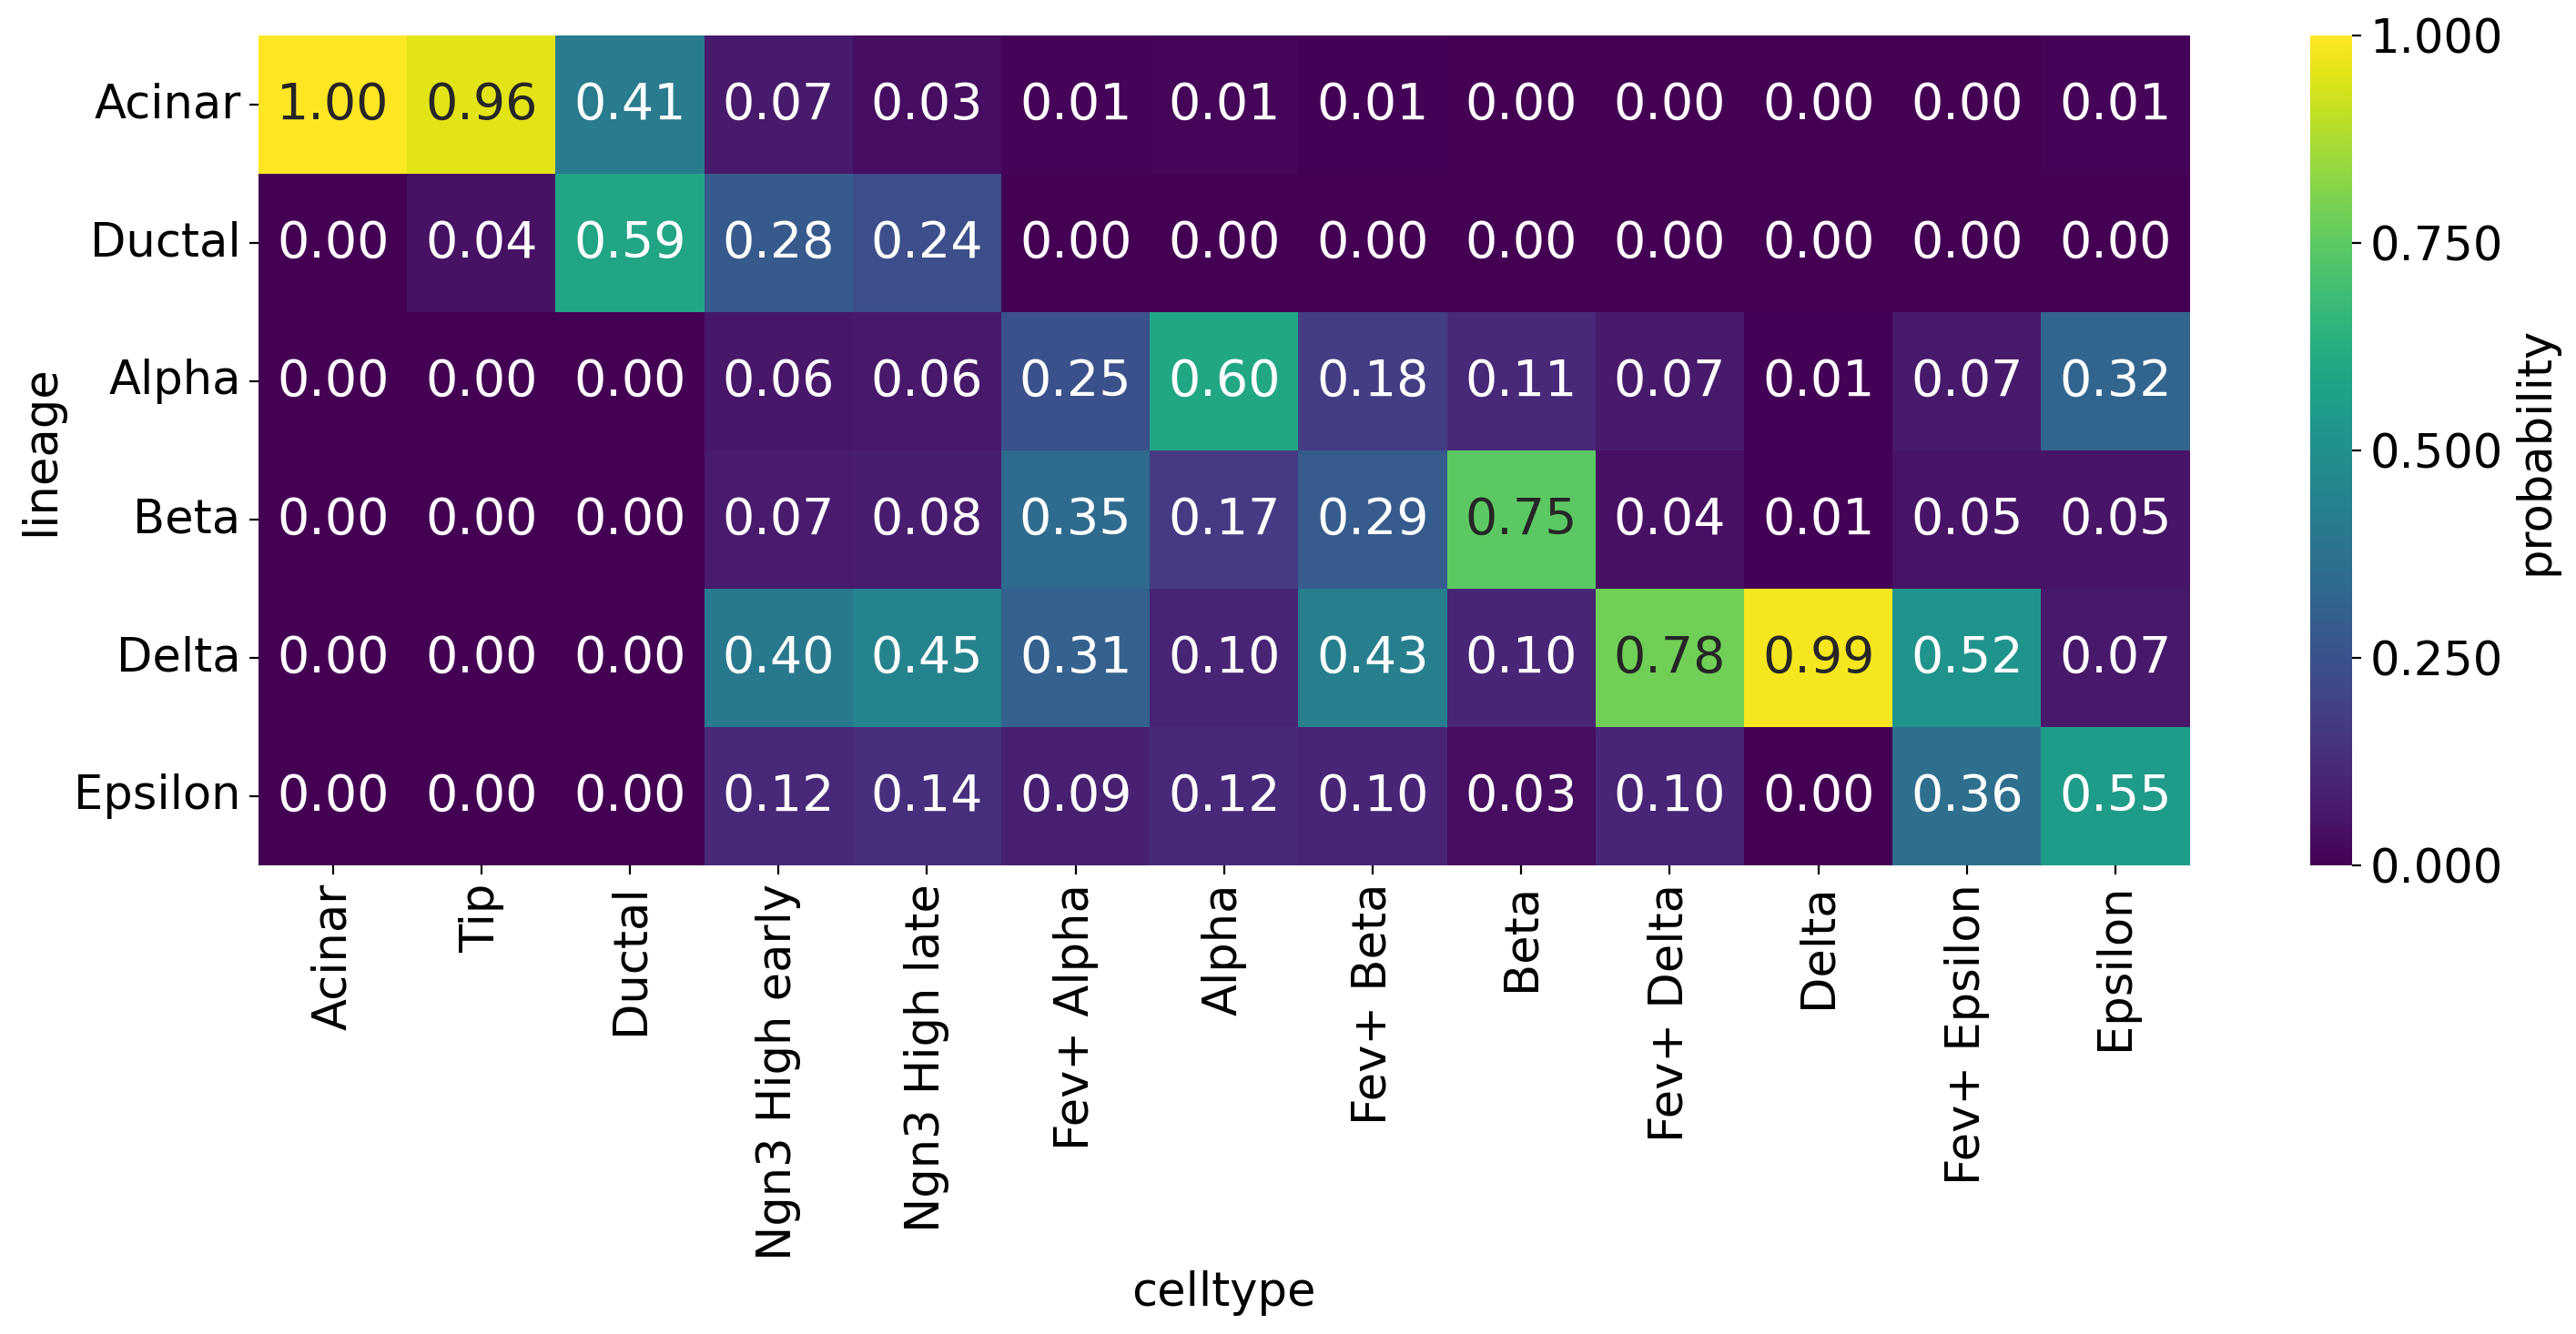

In [17]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')

cr.pl.aggregate_fate_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"],
    cluster_key='celltype',
    clusters=['Acinar', 'Tip', 'Ductal', 'Ngn3 High early','Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 6),
    title="",
)

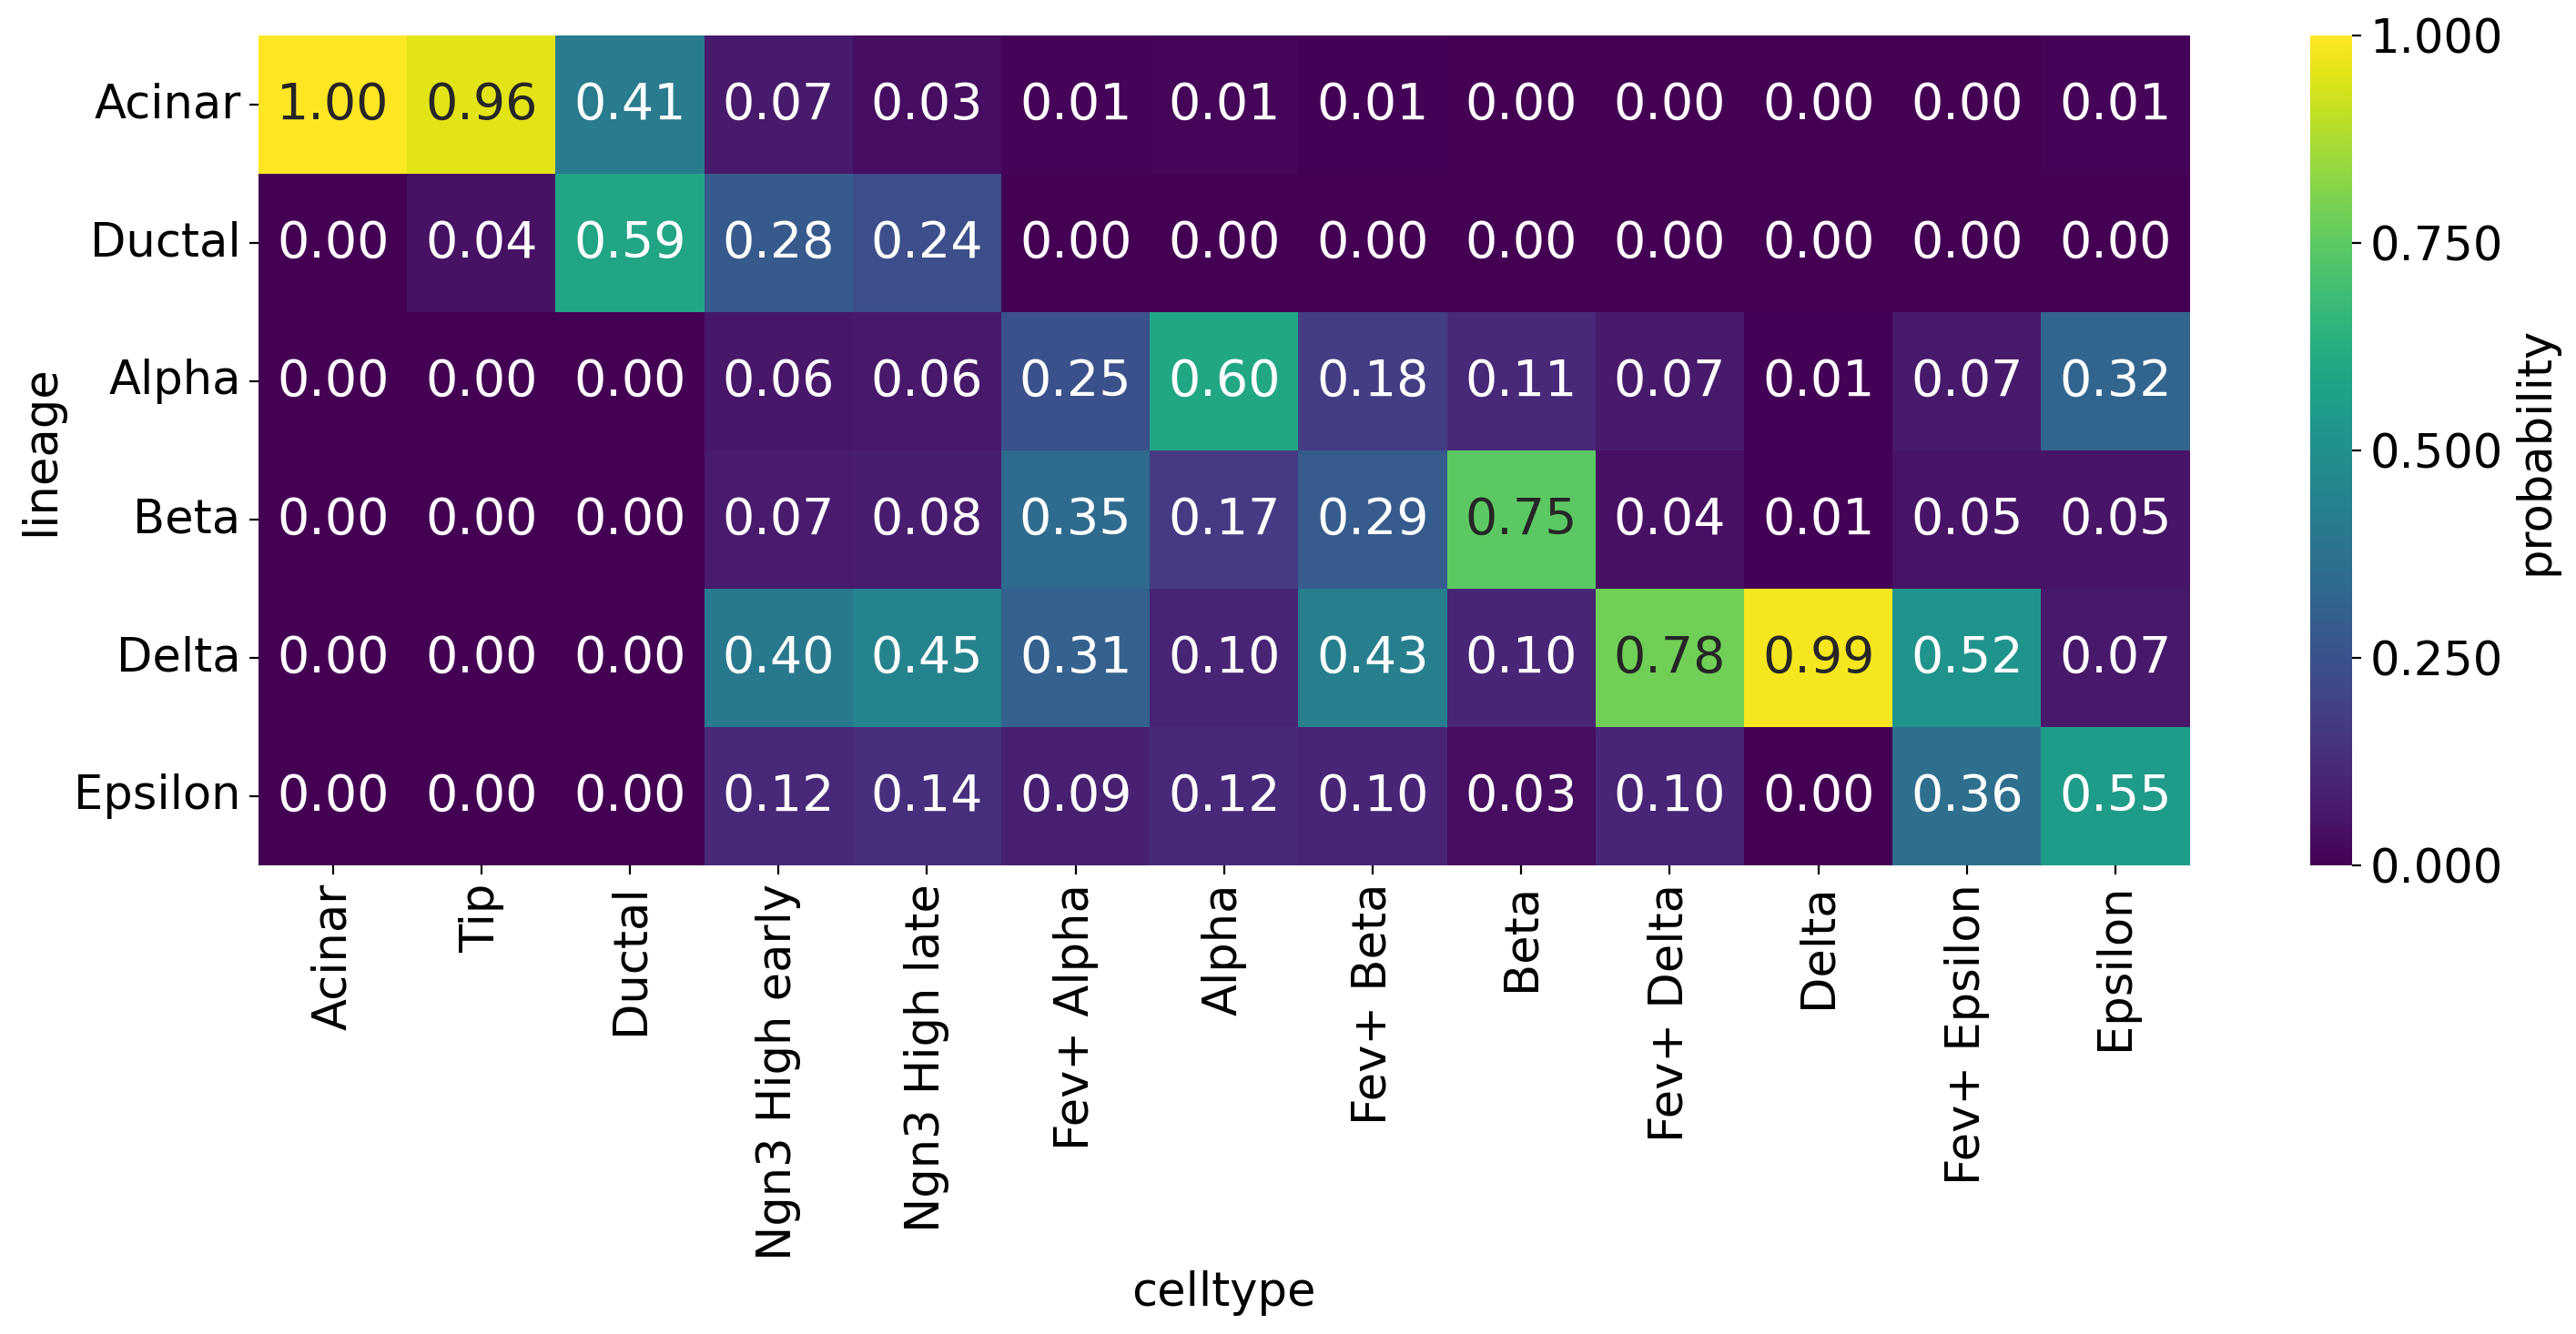

In [34]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')

cr.pl.aggregate_fate_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"],
    cluster_key='celltype',
    clusters=['Acinar', 'Tip', 'Ductal', 'Ngn3 High early','Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 6),
    title="",
)

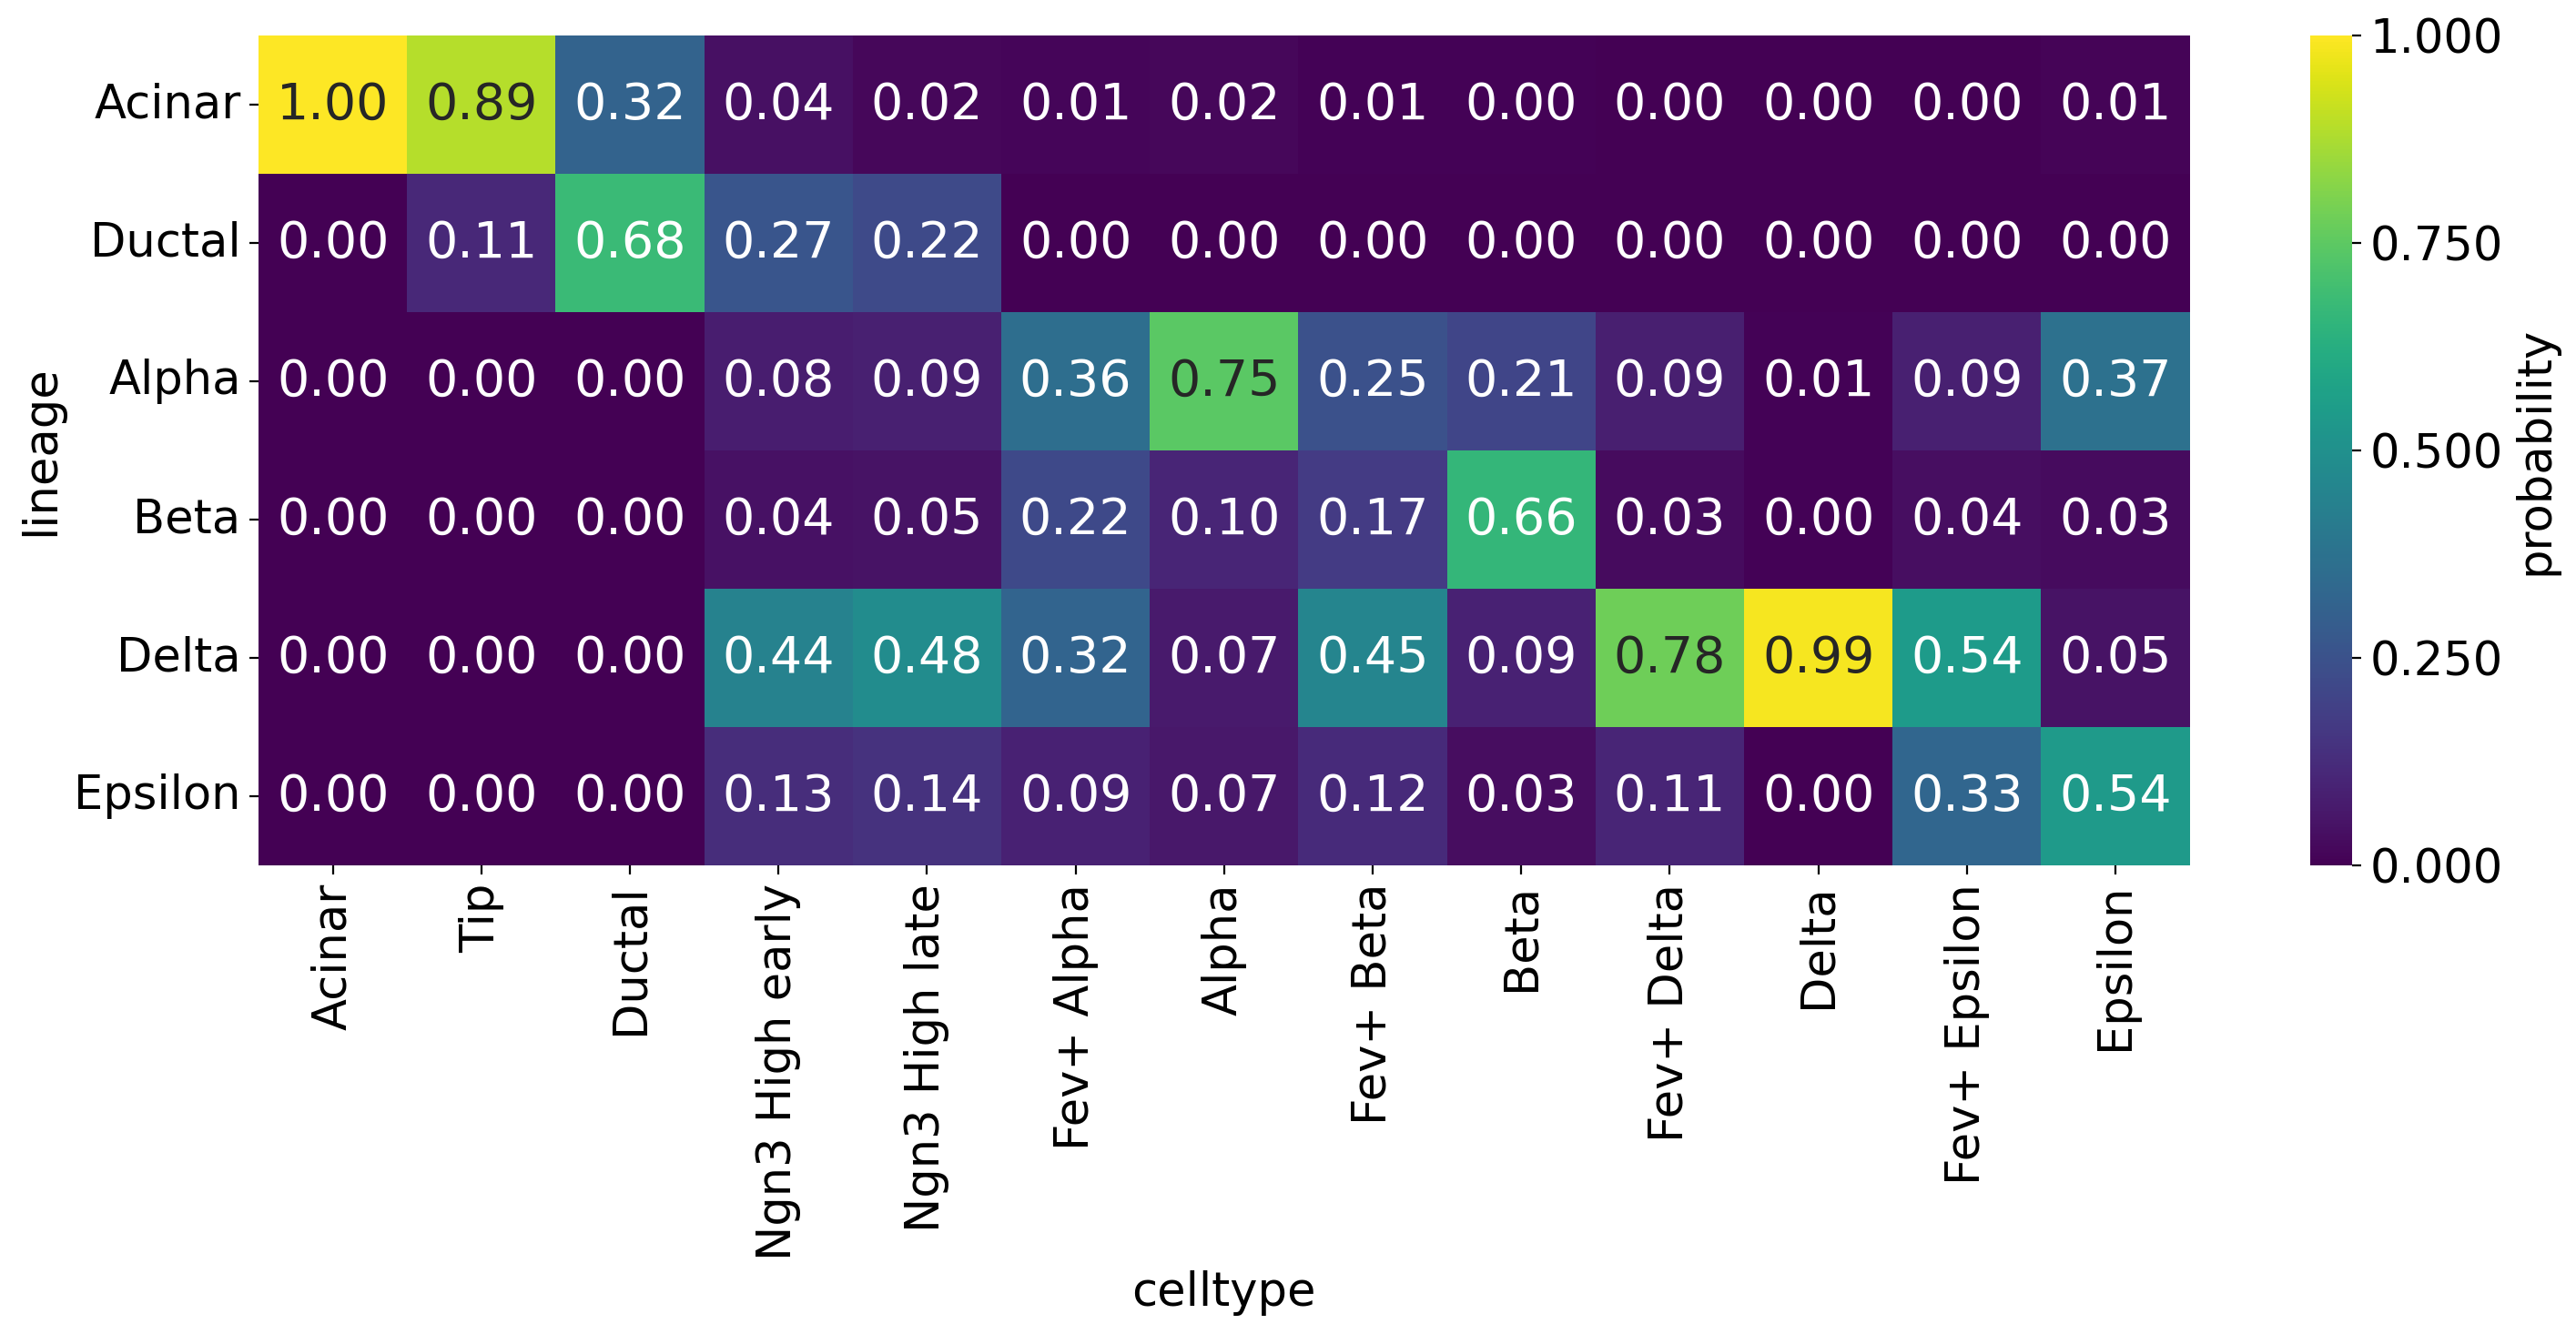

In [17]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')

cr.pl.aggregate_fate_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"],
    cluster_key='celltype',
    clusters=['Acinar', 'Tip', 'Ductal', 'Ngn3 High early','Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 6),
    title="",
)

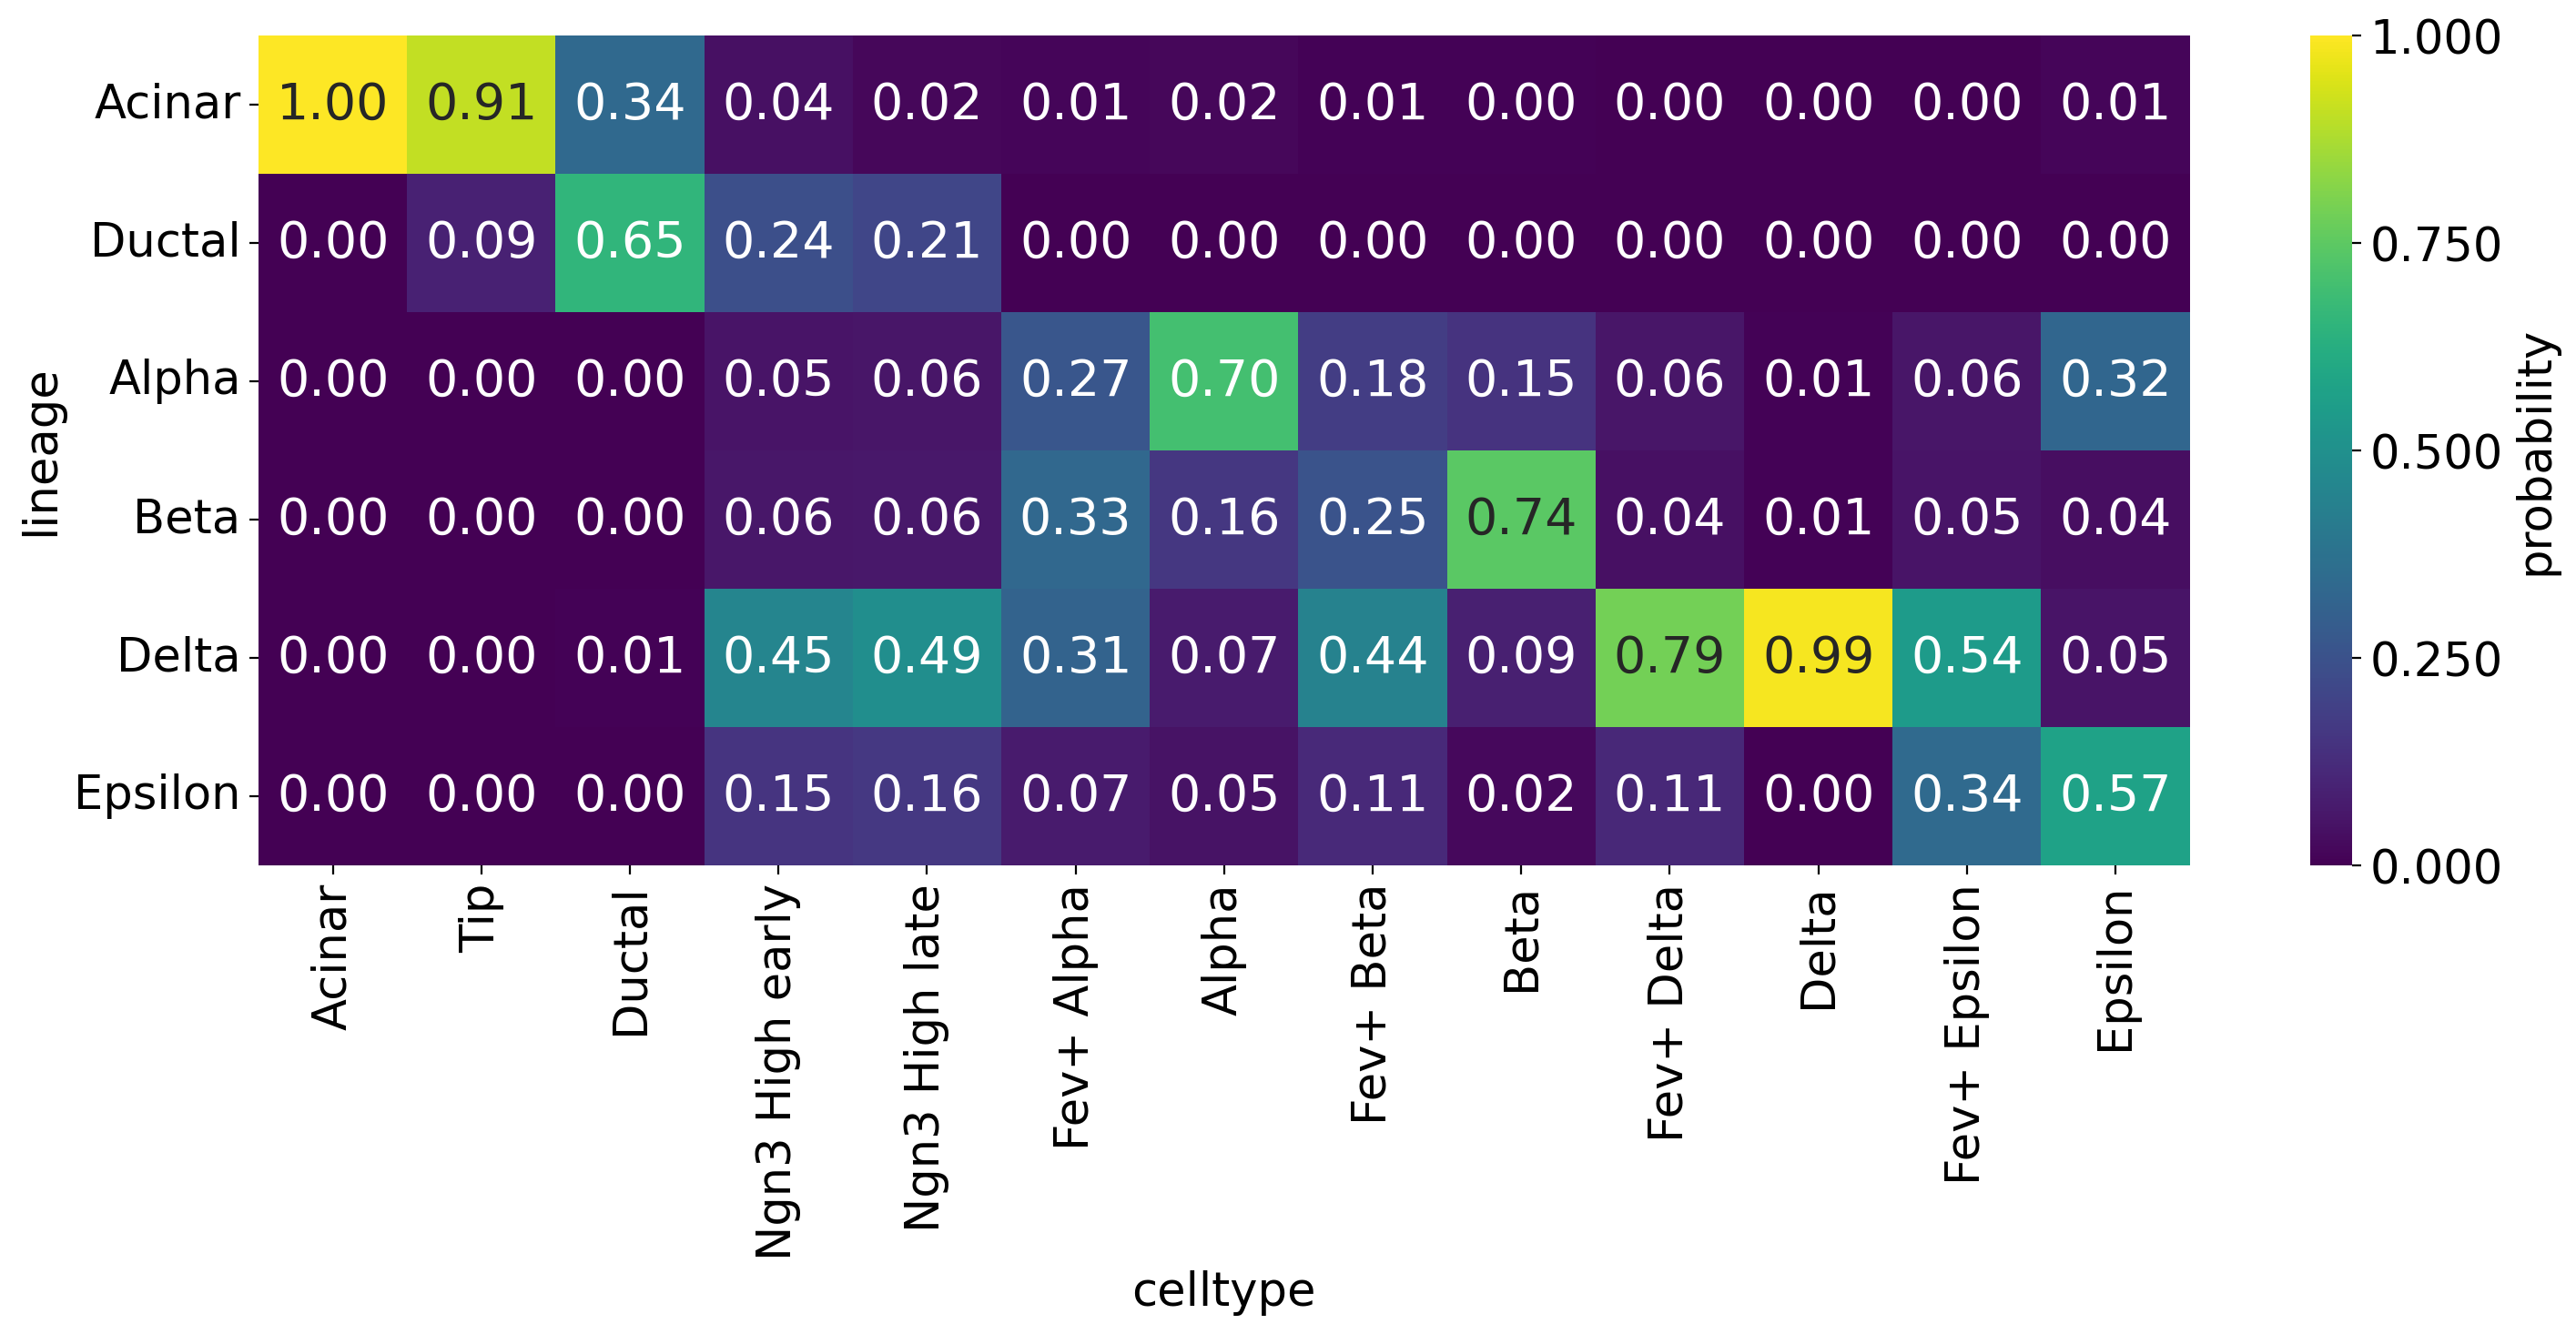

In [48]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')

cr.pl.aggregate_fate_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"],
    cluster_key='celltype',
    clusters=['Acinar', 'Tip', 'Ductal', 'Ngn3 High early','Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 6),
    title="",
)